In [341]:
import parflow as pf
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plot
import os.path, time
import pandas as pd
import seaborn as sns
import numpy as np

In [342]:
# pressure = pf.read_pfb("test_output_longer_run/sloping_slab_with_10000_reservoirs_releasing_no_rain/model.out.press.00010.pfb")
# pressure = pf.read_pfb("test_output/sloping_slab/model.out.press.00010.pfb")


In [343]:
# px.imshow(pressure[0], color_continuous_scale='Teal')

In [344]:
def calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition):
    run_times = {}
    run_times["preprocessing"] = {}
    run_times["first_time_step"] = {}
    run_times["second_time_step"] = {}
    run_times["rest_of_simulation"] = {}
    for amount in reservoir_amounts:
        folder = f"./test_output_longer_run/sloping_slab_with_{amount}_reservoirs_{reservoir_condition}_{rain_condition}"
        preprocessing_start_file = f"{folder}/start_file.txt"
        preprocessing_start_time = os.path.getctime(preprocessing_start_file)
        simulation_start_file = f"{folder}/model.out.press.00000.pfb"
        simulation_start_time = os.path.getctime(simulation_start_file)
        first_timestep_file = f"{folder}/model.out.press.00001.pfb"
        first_timestep_time = os.path.getctime(first_timestep_file)
        second_timestep_file = f"{folder}/model.out.press.00002.pfb"
        second_timestep_time = os.path.getctime(second_timestep_file)
        simulation_end_file = f"{folder}/model.out.press.00010.pfb"
        simulation_end_time = os.path.getctime(simulation_end_file)
        run_times["preprocessing"][amount] = (simulation_start_time-preprocessing_start_time)
        run_times["first_time_step"][amount] = (first_timestep_time-simulation_start_time)
        run_times["second_time_step"][amount] = (second_timestep_time-first_timestep_time)
        run_times["rest_of_simulation"][amount] = (simulation_end_time-second_timestep_time)
    return pd.DataFrame(run_times)



In [345]:
def get_surface_pressure(rain_condition, reservoir_condition):
    amount = 10000
    folder = f"./test_output_longer_run/sloping_slab_with_{amount}_reservoirs_{reservoir_condition}_{rain_condition}"
    pressure_file = f"{folder}/model.out.press.00010.pfb"
    pressure = pf.read_pfb(pressure_file)
    return pressure

In [346]:

def get_reservoir_mask(reservoir_file):
    df = pd.read_csv(reservoir_file)
    dx = 10.0
    dy = 10.0
    df.Intake_X = (df.Intake_X/dx).astype(int)
    df.Intake_Y = (df.Intake_Y/dy).astype(int)
    reservoir_mask = np.zeros([500,500])
    for reservoir in range(0,10000):
        reservoir_mask[df.Intake_Y[reservoir], df.Intake_X[reservoir]] = 1
    return reservoir_mask

reservoirs_releasing_mask = get_reservoir_mask("reservoir_files/10000_reservoirs_releasing.csv")
reservoirs_not_releasing_mask = get_reservoir_mask("reservoir_files/10000_reservoirs_not_releasing.csv")


In [347]:
reservoir_amounts = [0,1,10,100,1000,10000]

rain_condition = "constant_rain"
reservoir_condition = "not_releasing"
filling_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
filling_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# filling_pressure = np.where(reservoirs_not_releasing_mask==1, np.nan, filling_pressure)

rain_condition = "no_rain"
reservoir_condition = "releasing"
draining_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
draining_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# draining_pressure = np.where(reservoirs_releasing_mask==1, np.nan, filling_pressure)

rain_condition = "periodic_rainfall"
reservoir_condition = "releasing"
periodic_rainfall_runtimes = calculate_run_times(reservoir_amounts, rain_condition, reservoir_condition)
periodic_rainfall_pressure = get_surface_pressure(rain_condition, reservoir_condition)
# periodic_rainfall_pressure = np.where(reservoirs_releasing_mask==1, np.nan, filling_pressure)

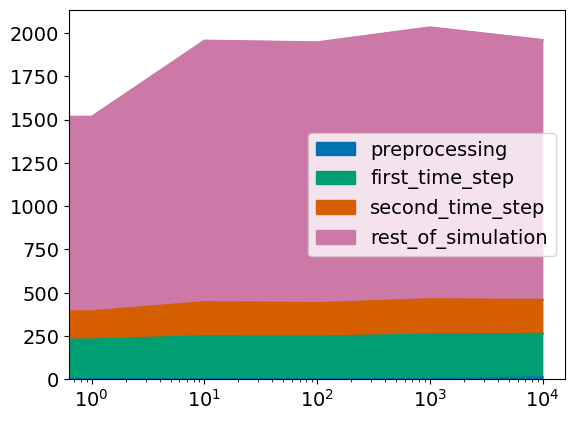

In [348]:
filling_runtimes.plot.area( logx=True)
mpl.style.use('seaborn-v0_8-colorblind')

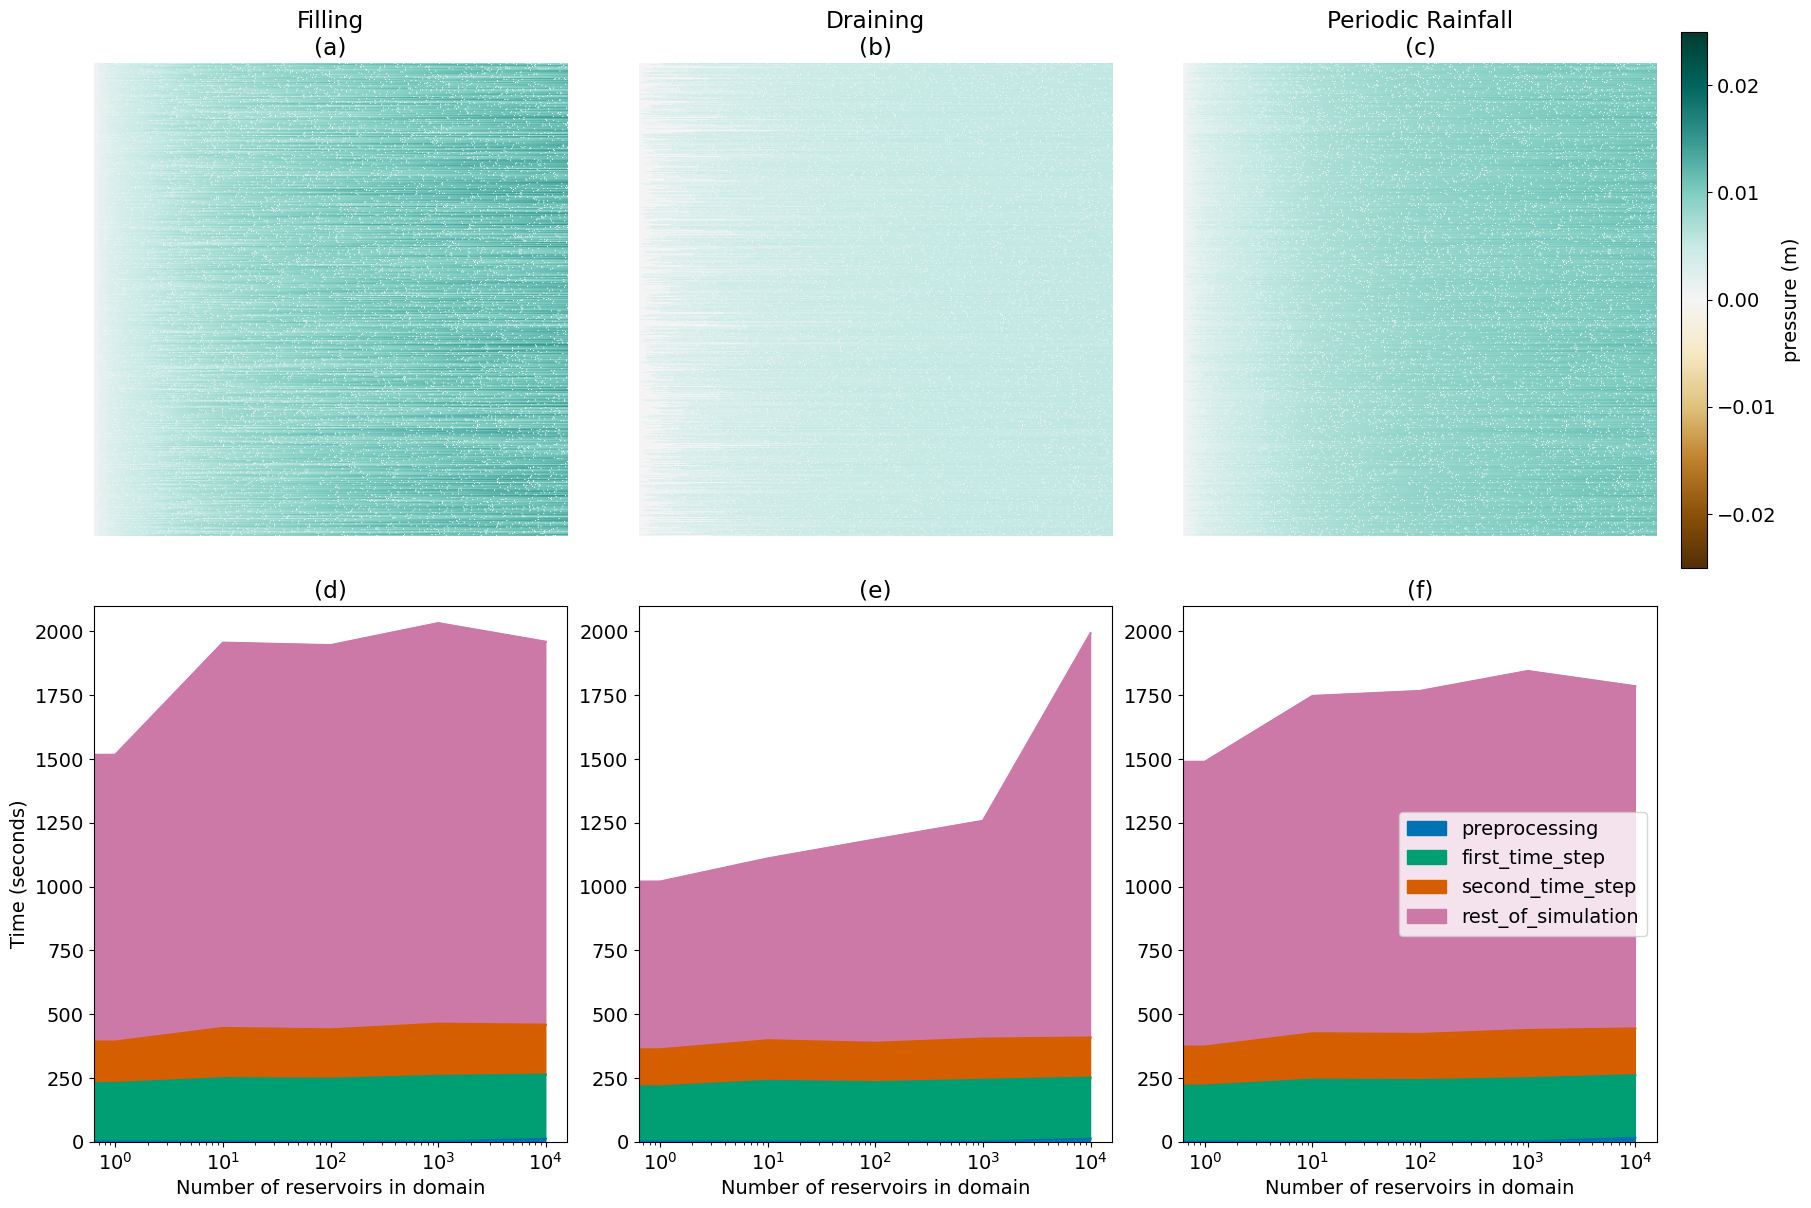

In [349]:
fig, axes = plot.subplots(2, 3, layout='constrained')
fig.set_figheight(12)
fig.set_figwidth(18)
plot.rcParams.update({'font.size': 14})
cmap = mpl.pyplot.get_cmap("BrBG")
# cmap.set_bad(color="grey")



filling_runtimes.plot.area( logx=True, ax = axes[1,0], legend=False, ylim=[0,2100])
axes[1,0].set_ylabel("Time (seconds)")
axes[1,0].set_xlabel("Number of reservoirs in domain")
draining_runtimes.plot.area( logx=True, ax = axes[1,1], legend=False, ylim=[0,2100])
axes[1,1].set_xlabel("Number of reservoirs in domain")
periodic_rainfall_runtimes.plot.area( logx=True, ax = axes[1,2], legend=True, ylim=[0,2100])
axes[1,2].set_xlabel("Number of reservoirs in domain")

filling_image =  axes[0,0].imshow(filling_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,0].grid(False)
axes[0,0].axis('off')

draining_image = axes[0,1].imshow(draining_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,1].grid(False)
axes[0,1].axis('off')

periodic_rainfall_image = axes[0,2].imshow(periodic_rainfall_pressure[0], vmin=-0.025, vmax=0.025, cmap=cmap)
axes[0,2].grid(False)
axes[0,2].axis('off')
colobar = plot.colorbar(periodic_rainfall_image, label="pressure (m)")



axes[0,0].title.set_text("Filling\n(a)")
axes[0,1].title.set_text("Draining\n(b)")
axes[0,2].title.set_text("Periodic Rainfall\n(c)")

axes[1,0].title.set_text("(d)")
axes[1,1].title.set_text("(e)")
axes[1,2].title.set_text("(f)")


# plot.colorbar(filling_image, ax=axes[0, 0])
# plot.colorbar(draining_image, ax=axes[0, 1])
# plot.colorbar(periodic_rainfall_image, ax=axes[0, 2])

# .imshow(filling_pressure[0])
# filling_pressure.imag(ax = axes[1,0])

# fig.



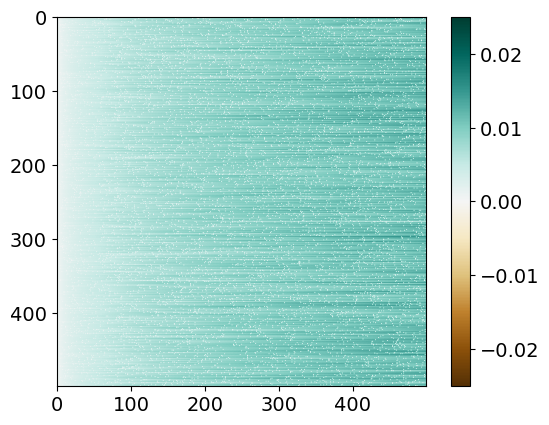

In [350]:
filling_image = plot.imshow(filling_pressure[0], vmin=-0.025, vmax=0.025, cmap="BrBG")
plot.colorbar()
# axes[0,0].grid(False)
# axes[0,0].axis('off')

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

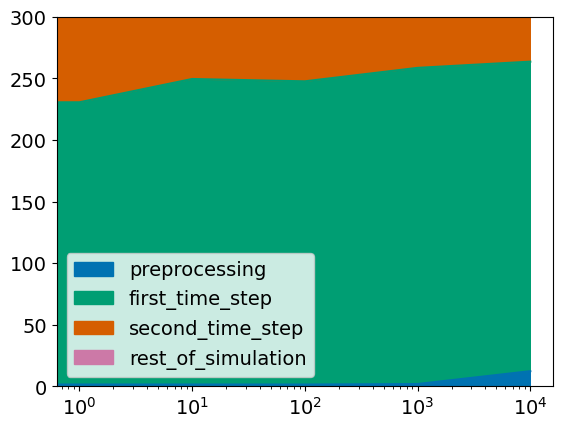

In [351]:
filling_runtimes.plot.area( logx=True, legend=True, ylim=[0,300])
plot.set_ylabel("Time (seconds)")
plot.set_xlabel("Number of reservoirs in domain")

In [ ]:
df = pd.read_csv("reservoir_files/10000_reservoirs_releasing.csv")
dx = 10.0
dy = 10.0
df.Intake_X = (df.Intake_X/dx).astype(int)
df.Intake_Y = (df.Intake_Y/dy).astype(int)
reservoir_mask = np.zeros([500,500])
for reservoir in range(0,10000):
    reservoir_mask[df.Intake_X[reservoir], df.Intake_Y[reservoir]] = 1

In [ ]:


df.Intake_X[1], df.Intake_Y[1]

(454, 479)

In [ ]:
px.imshow(reservoir_mask)